In [2]:
!mkdir -p /content/coco

# Download val images (~1GB)
!wget -q http://images.cocodataset.org/zips/val2017.zip -P /content/coco
!unzip -q /content/coco/val2017.zip -d /content/coco/

# Download annotations (~241MB)
!wget -q http://images.cocodataset.org/annotations/annotations_trainval2017.zip -P /content/coco
!unzip -q /content/coco/annotations_trainval2017.zip -d /content/coco/

In [3]:
import torchvision
from torchvision.datasets import CocoDetection
import torchvision.transforms as T
from pycocotools.coco import COCO

# Setup COCO val dataset (images + annotations)
val_dataset = CocoDetection(
    root='/content/coco/val2017',  # will download images here
    annFile='/content/coco/annotations/instances_val2017.json',
    transform=T.ToTensor()
)
coco = COCO('/content/coco/annotations/instances_val2017.json')
categories = coco.loadCats(coco.getCatIds())
cat_id_to_name = {cat['id']: cat['name'] for cat in categories}
cat_id_to_yolo_idx = {cat['id']: i for i, cat in enumerate(categories)}
yolo_idx_to_cat_id = {v: k for k, v in cat_id_to_yolo_idx.items()}

loading annotations into memory...
Done (t=0.85s)
creating index...
index created!
loading annotations into memory...
Done (t=0.73s)
creating index...
index created!


In [4]:
import matplotlib.pyplot as plt
from PIL import ImageDraw, ImageFont
import numpy as np
from collections import defaultdict
import torchvision.transforms as T
from ultralytics import YOLO
from torchvision.ops import box_iou
import numpy as np
import torch
import torchvision



def visualize_counting_examples(model, val_dataset, device, num_images=2, conf_threshold=0.1):
    """
    Visualizes example images from the dataset with predicted and true object counts.

    Args:
        model: The trained object detection model.
        val_dataset: The validation dataset (CocoDetection).
        device: The device to run inference on ('cuda' or 'cpu').
        num_images: The number of example images to display.
        conf_threshold: The confidence threshold for filtering predictions.
    """
    model.eval()
    processed_images = 0

    for i, (img, targets) in enumerate(val_dataset):
        if processed_images >= num_images:
            break

        img_tensor = img.to(device)

        with torch.no_grad():
            if isinstance(model, YOLO):
                # Ultralytics YOLOv8-style
                img_pil = T.ToPILImage()(img_tensor.cpu())
                results = model(img_pil, verbose=False)
                preds = results[0]
                pred_labels = preds.boxes.cls.cpu().numpy()
                pred_scores = preds.boxes.conf.cpu().numpy()

                # Apply YOLO index to COCO category ID mapping and filter by confidence threshold
                mapped_pred_labels = []
                filtered_scores = []
                filtered_boxes = []

                for j, (lbl, score, box) in enumerate(zip(pred_labels, pred_scores, preds.boxes.xyxy.cpu().numpy())):
                    mapped_lbl = yolo_idx_to_cat_id.get(int(lbl), -1)
                    if mapped_lbl != -1 and score >= conf_threshold:
                        mapped_pred_labels.append(mapped_lbl)
                        filtered_scores.append(score)
                        filtered_boxes.append(box)

                # Use the plot method from ultralytics results object if available
                # Note: This might not directly use our filtered boxes/labels for plotting
                # If precise plotting with filtered results is needed, manual drawing might be better
                try:
                     # Attempt to plot using the original results object but with filtered predictions
                     # This might require adapting or passing filtered results to the plot method if supported
                     # As a fallback, we'll plot the original predictions
                    img_display = preds.plot(img=np.array(img_pil))
                except:
                    # Fallback to plotting original predictions if filtered plotting is not straightforward
                    img_display = preds.plot(img=np.array(img_pil)) # Use plot method for visualization


                # Use mapped_pred_labels for counting
                filtered_pred_labels_for_counting = [label for label, score in zip(mapped_pred_labels, filtered_scores) if score >= conf_threshold]
                pred_counts = defaultdict(int)
                for label in filtered_pred_labels_for_counting:
                    pred_counts[int(label)] += 1


            else:
                # Torchvision-style model (SSD, Faster R-CNN, Mask R-CNN)
                # Need to convert the input image back to PIL for drawing

                img_pil = T.ToPILImage()(img_tensor.cpu())
                # Ensure input tensor is on the correct device before passing to the model
                outputs = model([img_tensor.to(device)])
                preds = outputs[0]
                pred_labels = preds['labels'].cpu().numpy()
                pred_scores = preds['scores'].cpu().numpy()
                pred_boxes = preds['boxes'].cpu().numpy()

                # Draw bounding boxes and labels on the PIL image
                img_display = img_pil.copy()
                draw = ImageDraw.Draw(img_display)
                font = ImageFont.load_default() # Or load a custom font

                pred_counts = defaultdict(int)
                for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
                    if score >= conf_threshold:
                        x1, y1, x2, y2 = box
                        draw.rectangle([(x1, y1), (x2, y2)], outline="red", width=2)
                        # You might need a mapping from label ID to class name here (for torchvision models, labels are usually COCO IDs)
                        class_name = cat_id_to_name.get(int(label), f"Class {label}")
                        draw.text((x1, y1), f"{class_name} ({score:.2f})", fill="red", font=font)
                        pred_counts[int(label)] += 1


        # Process GT labels
        if isinstance(targets, dict) and 'labels' in targets:
            gt_labels = targets['labels']
        elif isinstance(targets, torch.Tensor):
            gt_labels = targets
        else:
            # COCO-style: list of dicts with 'category_id'
            gt_labels = [ann['category_id'] for ann in targets]

        # Convert to NumPy if tensor
        if isinstance(gt_labels, torch.Tensor):
            gt_labels = gt_labels.cpu().numpy()
        else:
            gt_labels = np.array(gt_labels)

        gt_labels = gt_labels.flatten()

        gt_counts = defaultdict(int)
        for label in gt_labels:
            gt_counts[int(label)] += 1


        # Display the image and counts
        plt.figure(figsize=(10, 10))
        plt.imshow(img_display if 'YOLO' in str(type(model)) else np.array(img_display)) # YOLO plot returns numpy array
        plt.title(f"Image {i+1}\nTrue Counts: {dict(gt_counts)}\nPredicted Counts: {dict(pred_counts)}")
        plt.axis('off')
        plt.show()

        processed_images += 1





import torch
import torchvision

def calculate_and_display_instance_metrics(per_class_tp, per_class_fp, per_class_fn, cat_id_to_name):
    """
    Calculates and displays per-class and overall instance-based metrics (Precision, Recall, F1).

    Args:
        per_class_tp (defaultdict): Dictionary of true positives per class.
        per_class_fp (defaultdict): Dictionary of false positives per class.
        per_class_fn (defaultdict): Dictionary of false negatives per class.
        cat_id_to_name (dict): Mapping from COCO category ID to class name.
    """
    class_metrics = {}
    all_classes = set(per_class_tp.keys()).union(set(per_class_fp.keys()), set(per_class_fn.keys()))

    # Calculate per-class metrics
    for cls_id in all_classes:
        tp = per_class_tp[cls_id]
        fp = per_class_fp[cls_id]
        fn = per_class_fn[cls_id]

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

        class_metrics[cls_id] = {'precision': precision, 'recall': recall, 'f1': f1}

    # Sort classes by F1-score
    sorted_classes_by_f1 = sorted(class_metrics.items(), key=lambda item: item[1]['f1'], reverse=True)

    # Get top 5 and bottom 5 performing classes
    top_5_classes = sorted_classes_by_f1[: min(5, len(sorted_classes_by_f1))]
    bottom_5_classes = sorted_classes_by_f1[-min(5, len(sorted_classes_by_f1)):]


    print("\nPer-Class Metrics (IoU Threshold = 0.5):")
    print("\nTop Performing Classes (by F1-score):")
    for cls_id, metrics in top_5_classes:
        class_name = cat_id_to_name.get(cls_id, f"Class {cls_id}")
        print(f"  {class_name} (ID: {cls_id}): Precision={metrics['precision']:.3f}, Recall={metrics['recall']:.3f}, F1-score={metrics['f1']:.3f}")

    print("\nBottom Performing Classes (by F1-score):")
    # Ensure bottom_5_classes are distinct from top_5_classes if there are fewer than 10 classes
    bottom_5_classes_display = [item for item in bottom_5_classes if item not in top_5_classes]
    for cls_id, metrics in bottom_5_classes_display:
        class_name = cat_id_to_name.get(cls_id, f"Class {cls_id}")
        print(f"  {class_name} (ID: {cls_id}): Precision={metrics['precision']:.3f}, Recall={metrics['recall']:.3f}, F1-score={metrics['f1']:.3f}")

    # Calculate overall instance-based metrics
    total_tp = sum(per_class_tp.values())
    total_fp = sum(per_class_fp.values())
    total_fn = sum(per_class_fn.values())

    overall_precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0.0
    overall_recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0.0
    overall_f1 = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall) if (overall_precision + overall_recall) > 0 else 0.0

    print(f"\nOverall Instance-Based Metrics (IoU Threshold = 0.5):")
    print(f"Overall Precision: {overall_precision:.3f}")
    print(f"Overall Recall: {overall_recall:.3f}")
    print(f"Overall F1-score: {overall_f1:.3f}")


import numpy as np
from collections import defaultdict

def mean_absolute_error(gt_counts_list, pred_counts_list):
    """Calculates the Mean Absolute Error (MAE) between ground truth and predicted counts."""
    abs_diffs = []
    for gt_counts, pred_counts in zip(gt_counts_list, pred_counts_list):
        classes = set(gt_counts.keys()).union(set(pred_counts.keys()))
        diff = sum(abs(gt_counts.get(c, 0) - pred_counts.get(c, 0)) for c in classes)
        abs_diffs.append(diff)
    return np.mean(abs_diffs)

def root_mean_squared_error(gt_counts_list, pred_counts_list):
    """Calculates the Root Mean Squared Error (RMSE) between ground truth and predicted counts."""
    squared_diffs = []
    for gt_counts, pred_counts in zip(gt_counts_list, pred_counts_list):
        classes = set(gt_counts.keys()).union(set(pred_counts.keys()))
        diff_sq = sum((gt_counts.get(c, 0) - pred_counts.get(c, 0))**2 for c in classes)
        squared_diffs.append(diff_sq)
    return np.sqrt(np.mean(squared_diffs))

def mean_relative_root_mean_squared_error(gt_counts_list, pred_counts_list):
    """Calculates the Mean Relative Root Mean Squared Error (m-relRMSE)."""
    relative_squared_errors = []
    for gt_counts, pred_counts in zip(gt_counts_list, pred_counts_list):
        classes = set(gt_counts.keys()).union(set(pred_counts.keys()))
        sum_sq_diff = sum((gt_counts.get(c, 0) - pred_counts.get(c, 0))**2 for c in classes)
        sum_gt_sq = sum(gt_counts.get(c, 0)**2 for c in classes)

        if sum_gt_sq == 0:
            # If there are no ground truth objects, the relative error is 0 if there are also no predictions.
            # Otherwise, it's a large error. We'll treat it as 0 if no predictions, and include the squared diff if there are predictions.
             if sum_sq_diff > 0:
                 # If sum_gt_sq is 0 and sum_sq_diff is > 0, we'll skip this image for this metric
                 # as the relative error is infinite.
                 continue
             else:
                 relative_squared_errors.append(0) # No gt and no pred, relative error is 0
        else:
            relative_squared_error = sum_sq_diff / sum_gt_sq
            relative_squared_errors.append(relative_squared_error)

    if not relative_squared_errors: # Handle case where all images had sum_gt_sq == 0 and sum_sq_diff > 0
        return 0.0 # Or np.nan, depending on desired behavior for this edge case

    return np.sqrt(np.mean(relative_squared_errors))

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Faster R-CNN

In [5]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from collections import defaultdict
import numpy as np
from sklearn.metrics import average_precision_score


device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load pretrained Faster R-CNN
model = fasterrcnn_resnet50_fpn(pretrained=True).to(device)
model.eval()

all_gt_counts = []
all_pred_counts = []

# Dictionaries to accumulate per-class true positives, false positives, and false negatives
per_class_tp = defaultdict(int)
per_class_fp = defaultdict(int)
per_class_fn = defaultdict(int)


for i, (img, targets) in enumerate(val_dataset):

    img = img.to(device)

    with torch.no_grad():
        outputs = model([img])

    preds = outputs[0]
    pred_labels = preds['labels'].cpu().numpy()
    pred_scores = preds['scores'].cpu().numpy()
    pred_boxes = preds['boxes'].cpu().numpy()

    conf_threshold = 0.6
    filtered_indices = pred_scores >= conf_threshold
    filtered_labels = pred_labels[filtered_indices]
    filtered_boxes = pred_boxes[filtered_indices]


    pred_counts = defaultdict(int)
    for label in filtered_labels:
        pred_counts[int(label)] += 1

    gt_labels = [ann['category_id'] for ann in targets]
    gt_counts = defaultdict(int)
    for label in gt_labels:
        gt_counts[int(label)] += 1

    all_pred_counts.append(pred_counts)
    all_gt_counts.append(gt_counts)

    # Prepare ground truth for instance-based metrics
    gt_boxes_img = []
    gt_labels_img = []
    for ann in targets:
        # Ensure 'bbox' and 'category_id' keys exist and 'bbox' is not None
        if 'bbox' in ann and 'category_id' in ann and ann['bbox'] is not None:
             # Convert [x,y,w,h] to [x1,y1,x2,y2] and append
            bbox = ann['bbox']
            x, y, w, h = bbox
            gt_boxes_img.append(torch.tensor([[x, y, x + w, y + h]], dtype=torch.float32))
            gt_labels_img.append(torch.tensor([ann['category_id']], dtype=torch.int64))

    if not gt_boxes_img:
        gt_boxes_img_tensor = torch.empty((0, 4), dtype=torch.float32)
        gt_labels_img_tensor = torch.empty((0,), dtype=torch.int64)
    else:
        gt_boxes_img_tensor = torch.cat(gt_boxes_img, dim=0).to(device)
        gt_labels_img_tensor = torch.cat(gt_labels_img, dim=0).to(device)

    pred_boxes_img = torch.from_numpy(filtered_boxes).to(device)
    pred_labels_img = torch.from_numpy(filtered_labels).int().to(device)


    # Calculate IoU between predicted and ground truth boxes for the current image
    if pred_boxes_img.size(0) > 0 and gt_boxes_img_tensor.size(0) > 0:
        iou_matrix = torchvision.ops.box_iou(pred_boxes_img, gt_boxes_img_tensor)

        # Match predictions to ground truth based on IoU and labels (Greedy Matching)
        matched_gt = set()
        image_tp = 0
        for p_idx in range(pred_boxes_img.size(0)):
            best_iou = 0
            best_gt_idx = -1
            for gt_idx in range(gt_boxes_img_tensor.size(0)):
                if gt_idx not in matched_gt and pred_labels_img[p_idx] == gt_labels_img_tensor[gt_idx]:
                    if iou_matrix[p_idx, gt_idx] > best_iou:
                        best_iou = iou_matrix[p_idx, gt_idx]
                        best_gt_idx = gt_idx

            if best_gt_idx != -1 and best_iou >= 0.5: # Using 0.5 IoU threshold for matching
                per_class_tp[int(pred_labels_img[p_idx])] += 1
                matched_gt.add(best_gt_idx)
                image_tp += 1

        # Count False Positives (predicted boxes not matched to any ground truth)
        image_fp = pred_boxes_img.size(0) - image_tp
        for p_idx in range(pred_boxes_img.size(0)):
            # Check if this prediction was NOT matched as a TP
            is_matched_tp = False
            for gt_idx in matched_gt:
                if pred_labels_img[p_idx] == gt_labels_img_tensor[gt_idx] and torchvision.ops.box_iou(pred_boxes_img[p_idx].unsqueeze(0), gt_boxes_img_tensor[gt_idx].unsqueeze(0))[0, 0] >= 0.5:
                     is_matched_tp = True
                     break
            if not is_matched_tp:
                 per_class_fp[int(pred_labels_img[p_idx])] += 1


        # Count False Negatives (ground truth boxes not matched by any prediction)
        all_gt_indices = set(range(gt_boxes_img_tensor.size(0)))
        unmatched_gt_indices = list(all_gt_indices - matched_gt)
        for gt_idx in unmatched_gt_indices:
             per_class_fn[int(gt_labels_img_tensor[gt_idx])] += 1

    elif pred_boxes_img.size(0) > 0 and gt_boxes_img_tensor.size(0) == 0:
        # All predictions are False Positives if no ground truth
        for p_idx in range(pred_boxes_img.size(0)):
            per_class_fp[int(pred_labels_img[p_idx])] += 1
    elif pred_boxes_img.size(0) == 0 and gt_boxes_img_tensor.size(0) > 0:
        # All ground truths are False Negatives if no predictions
        for gt_idx in range(gt_labels_img_tensor.size(0)):
            per_class_fn[int(gt_labels_img_tensor[gt_idx])] += 1


# Calculate and display per-class and overall instance-based metrics
print("\nFaster R-CNN - Instance-Based Metrics:")
calculate_and_display_instance_metrics(per_class_tp, per_class_fp, per_class_fn, cat_id_to_name)


# Average counting metrics
mae = mean_absolute_error(all_gt_counts, all_pred_counts)
print(f"\nFaster R-CNN - Mean Absolute Error (MAE): {mae:.3f}")

rmse = root_mean_squared_error(all_gt_counts, all_pred_counts)
print(f"Faster R-CNN - Root Mean Squared Error (RMSE): {rmse:.3f}")

m_relrmse = mean_relative_root_mean_squared_error(all_gt_counts, all_pred_counts)
print(f"Faster R-CNN - Mean Relative Root Mean Squared Error (m-relRMSE): {m_relrmse:.3f}")

correct_counts = 0
for gt, pred in zip(all_gt_counts, all_pred_counts):
    classes = set(gt.keys()).union(set(pred.keys()))
    if all(gt.get(c, 0) == pred.get(c, 0) for c in classes):
        correct_counts += 1
counting_accuracy = correct_counts / len(all_gt_counts)
print(f"Faster R-CNN - Counting Accuracy: {counting_accuracy * 100:.2f}%")

num_classes = max(max(gt.keys(), default=0) for gt in all_gt_counts) + 1

gt_binary = []
pred_binary = []

for cls_id in range(num_classes):
    for gt, pred in zip(all_gt_counts, all_pred_counts):
        gt_binary.append(1 if gt.get(cls_id, 0) > 0 else 0)
        pred_binary.append(1 if pred.get(cls_id, 0) > 0 else 0)

ap = average_precision_score(gt_binary, pred_binary)
print(f"Faster R-CNN - Simplified Average Precision:  {ap * 100:.2f}%")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 183MB/s]  



Faster R-CNN - Instance-Based Metrics:

Per-Class Metrics (IoU Threshold = 0.5):

Top Performing Classes (by F1-score):
  cat (ID: 17): Precision=0.820, Recall=0.881, F1-score=0.850
  giraffe (ID: 25): Precision=0.812, Recall=0.875, F1-score=0.842
  zebra (ID: 24): Precision=0.799, Recall=0.862, F1-score=0.829
  fire hydrant (ID: 11): Precision=0.827, Recall=0.802, F1-score=0.814
  bear (ID: 23): Precision=0.833, Recall=0.775, F1-score=0.803

Bottom Performing Classes (by F1-score):
  knife (ID: 49): Precision=0.462, Recall=0.282, F1-score=0.350
  spoon (ID: 50): Precision=0.432, Recall=0.289, F1-score=0.346
  book (ID: 84): Precision=0.306, Recall=0.327, F1-score=0.316
  handbag (ID: 31): Precision=0.422, Recall=0.252, F1-score=0.316
  hair drier (ID: 89): Precision=0.000, Recall=0.000, F1-score=0.000

Overall Instance-Based Metrics (IoU Threshold = 0.5):
Overall Precision: 0.608
Overall Recall: 0.618
Overall F1-score: 0.613

Faster R-CNN - Mean Absolute Error (MAE): 3.852
Faster R-C

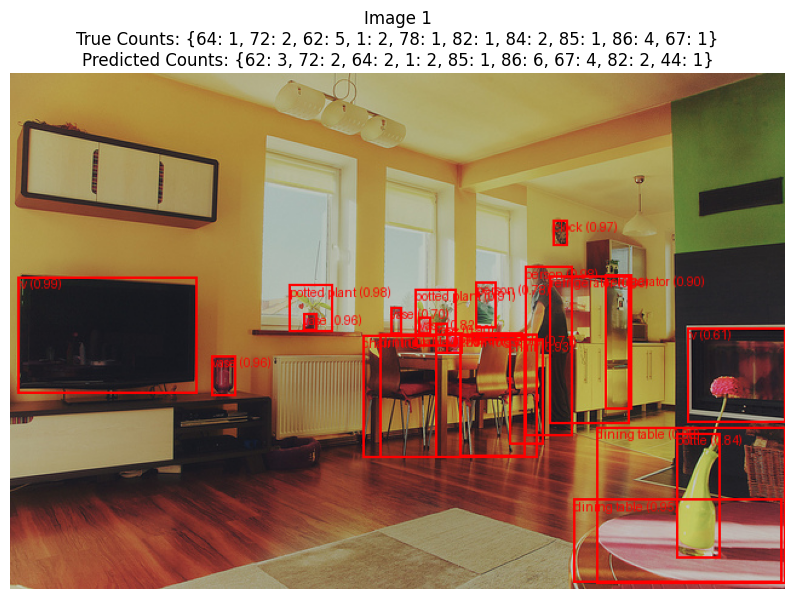

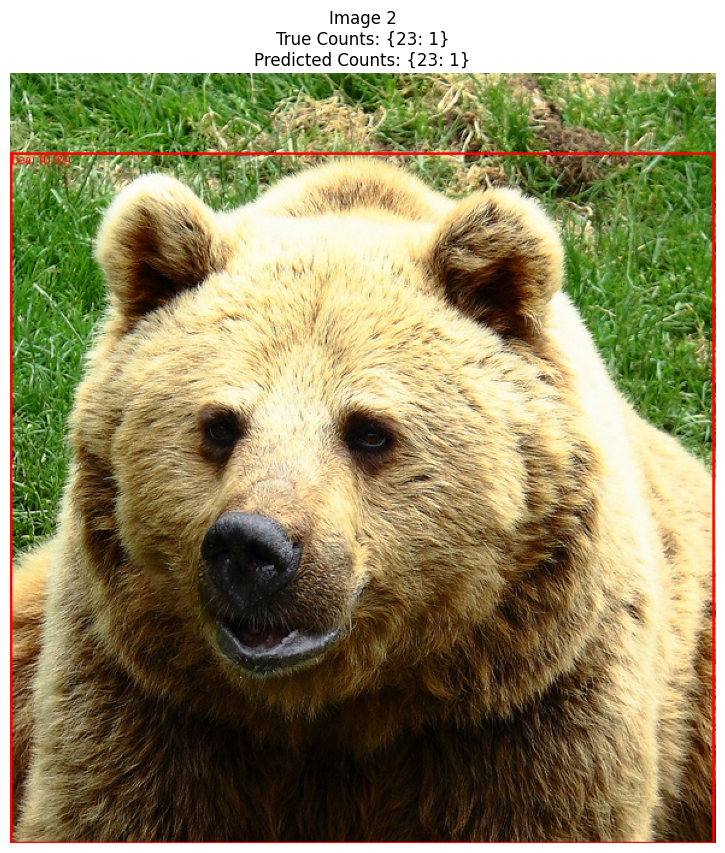

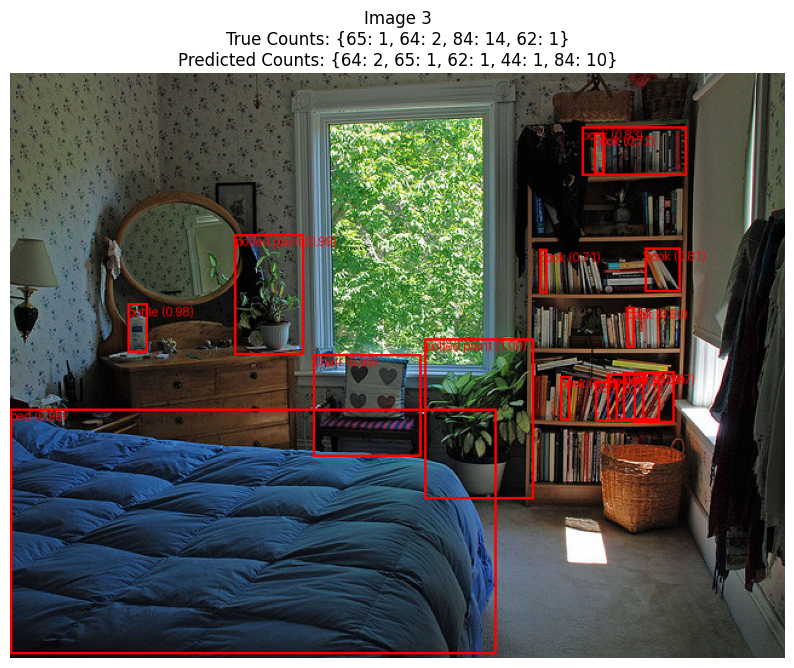

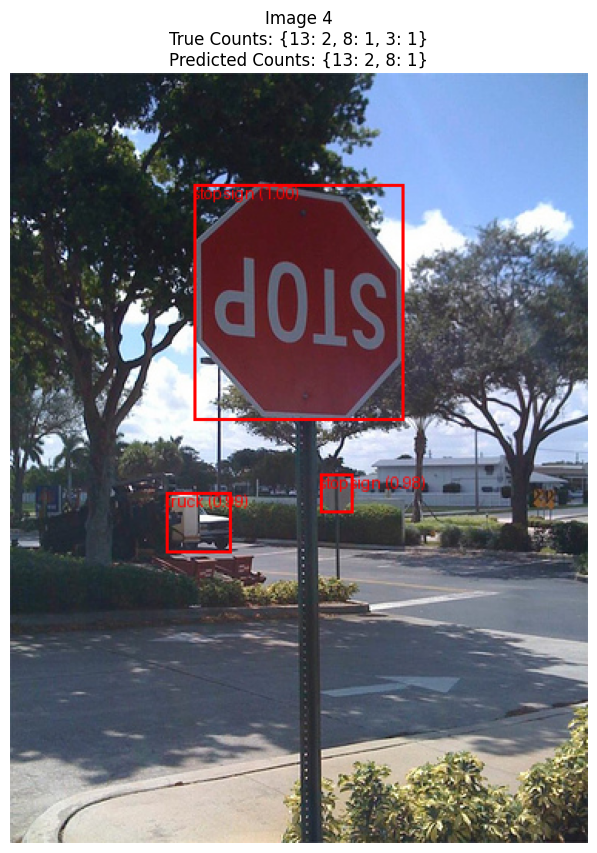

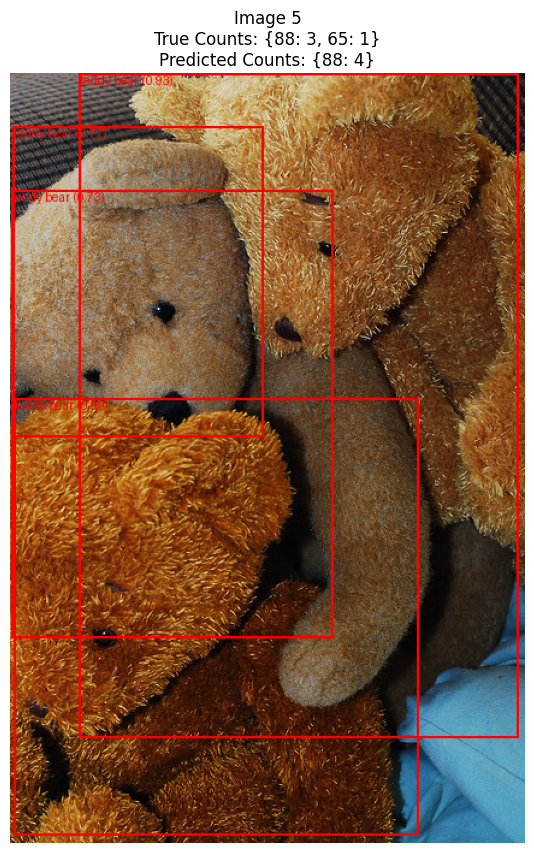

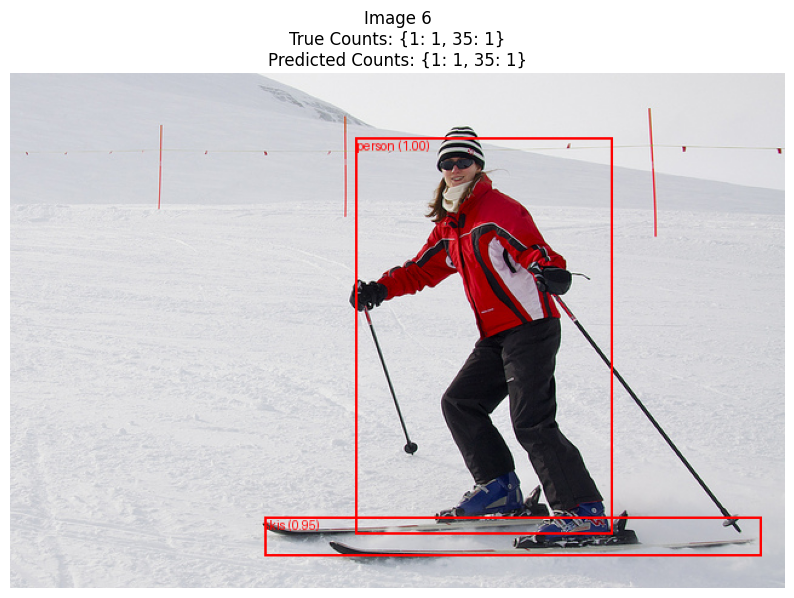

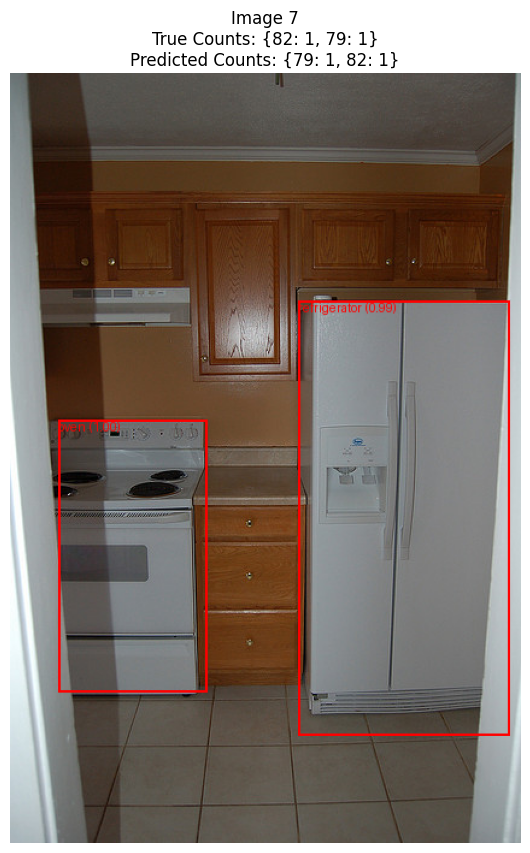

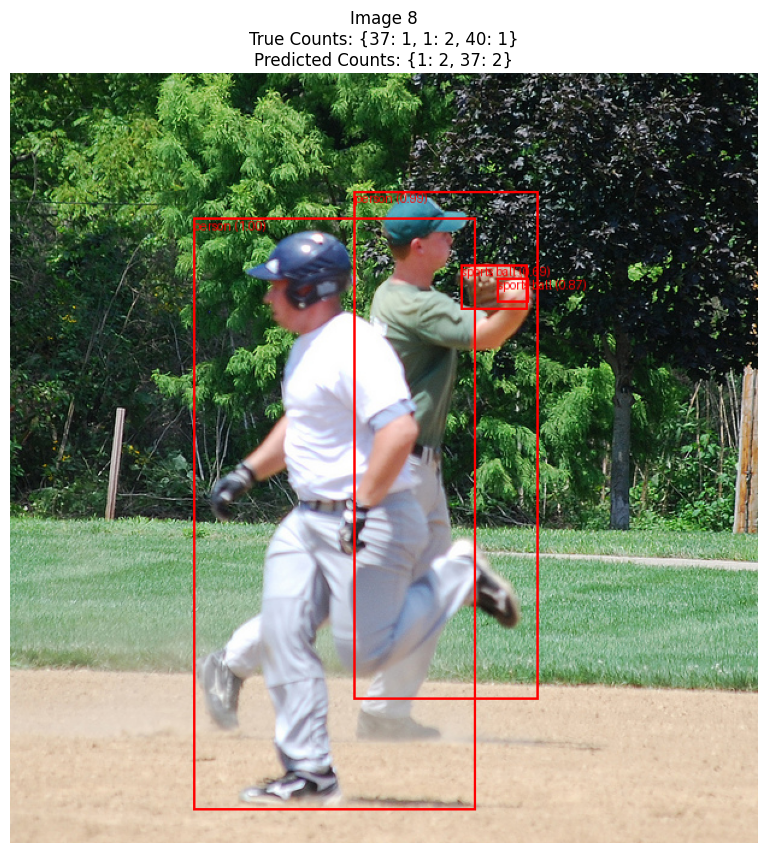

In [6]:
visualize_counting_examples(model, val_dataset, device, num_images=8, conf_threshold=0.6)